# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

* [Step 0](#step0): Import Modules
* [Step 1](#step1): Import & Load Datasets
* [Step 2](#step2): Detect Humans
* [Step 3](#step3): Detect Dogs
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Modules

In [1]:
import numpy as np
import cv2                
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import json
import torch.optim as optim

from glob import glob
from tqdm import tqdm
from PIL import Image, ImageFile 
from torchvision import datasets
                      
%matplotlib inline  

# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

---
<a id='step1'></a>
## Step 1: Import & Load Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [3]:
# load filenames for human and dog images
human_files = np.array(glob("../../lfw/*/*"))
dog_files = np.array(glob("../../dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [4]:
dog_data_dir = '../../dogImages'
human_data_dir = '../../lfw'

def get_data_dir(is_dog):
    
    data_dir = dog_data_dir if is_dog else human_data_dir
    
    if not is_dog:
        return {
        'train_dir': data_dir,
        'valid_dir': data_dir,
        'test_dir': data_dir
    }
    
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    
    return {
        'train_dir': train_dir,
        'valid_dir': valid_dir,
        'test_dir': test_dir
    }

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.ColorJitter(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomPerspective(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation((-90, 90)),
                                       transforms.RandomResizedCrop(224),              
                                       transforms.ToTensor(),  
                                       normalize])

valid_transforms = transforms.Compose([transforms.Resize(256), 
                                       transforms.CenterCrop(224),              
                                       transforms.ToTensor(), 
                                       normalize])

test_transforms = transforms.Compose([transforms.Resize(256), 
                                       transforms.CenterCrop(224),              
                                       transforms.ToTensor(), 
                                       normalize])

def get_dataset(is_dog, batch_sizes=[32, 32, 32]):
  
  data_dir_dict = get_data_dir(is_dog)
    
  train_dir = data_dir_dict['train_dir']
  valid_dir = data_dir_dict['valid_dir']
  test_dir = data_dir_dict['test_dir']
  
  train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
  valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
  test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

  return {
      'train': train_data,
      'valid': valid_data,
      'test': test_data
  }

def get_data_loaders(is_dog, batch_sizes=[32, 32, 32]):
    
    datasets = get_dataset(is_dog, batch_sizes)

    train_loader = torch.utils.data.DataLoader(datasets['train'], batch_size=batch_sizes[0], shuffle=True)
    valid_loader = torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_sizes[1], shuffle=True)
    test_loader = torch.utils.data.DataLoader(datasets['test'], batch_size=batch_sizes[2], shuffle=True)
    
    return {
        'train': train_loader,
        'valid': valid_loader,
        'test': test_loader
    }


dog_data_loaders = get_data_loaders(is_dog=True)
# ppl_data_loaders = get_data_loaders(is_dog=False)

<a id='step2'></a>
## Step 2: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


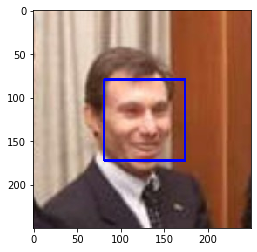

In [16]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('../../haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [0]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

files_size = 100

human_correct_face_count = 0
dog_correct_face_count = 0

for i in tqdm(range(files_size)):
    if face_detector(human_files_short[i]):
        human_correct_face_count += 1
        
for i in tqdm(range(files_size)):
    if face_detector(dog_files_short[i]):
        dog_correct_face_count += 1
        
print("Face dectection in first 100 images in human_files : {}%".format(
    (human_correct_face_count / files_size) * 100))
print("Face dectection in first 100 images in dog_files : {}%".format(
    (dog_correct_face_count / files_size) * 100))


100%|██████████| 100/100 [00:17<00:00,  5.70it/s]

Face dectection in first 100 images in human_files : 99.0%
Face dectection in first 100 images in dog_files : 18.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path)
    
    image_tensor = transforms.Compose([transforms.ToTensor()])(image).unsqueeze(0)
    
    ps = VGG16(image_tensor)
    
    top_p, top_class = ps.topk(1, dim=1)
    
    return top_class.numpy().item(0)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    predicted_index = VGG16_predict(img_path)
    
    return predicted_index >= 151 and predicted_index <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [0]:
files_size = 100

human_correct_dog_count = 0
dog_correct_dog_count = 0

for i in tqdm(range(files_size)):
    if dog_detector(human_files_short[i]):
        human_correct_dog_count += 1
        
for i in tqdm(range(files_size)):
    if dog_detector(dog_files_short[i]):
        dog_correct_dog_count += 1
        
print("Dog dectection in first 100 images in human_files : {}%".format(
    (human_correct_dog_count / files_size) * 100))
print("Dog dectection in first 100 images in dog_files : {}%".format(
    (dog_correct_dog_count / files_size) * 100))


100%|██████████| 100/100 [08:07<00:00,  4.88s/it]

Dog dectection in first 100 images in human_files : 0.0%
Dog dectection in first 100 images in dog_files : 88.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [0]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="../../images/Brittany_02625.jpg" width="100"> | <img src="../../images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="../../images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="../../images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="../../images/Labrador_retriever_06457.jpg" width="150"> | <img src="../../images/Labrador_retriever_06455.jpg" width="240"> | <img src="../../images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

See [Step 1](#step1): Import & Load Datasets

In [0]:
loaders_scratch = dog_data_loaders

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

* My code resizes the images by
    * cropping the given PIL Image and resizing it to 224px
* Yes
    * randomly changing the brightness, contrast and saturation of an image
    * horizontally flipping the given PIL Image randomly with a given probability
    * performing perspective transformation of the given PIL Image randomly with a given probability
    * vertically flipping the given PIL Image randomly with a given probability
    * rotating the image by angle ranging from -90 to 90

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [0]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self, num_classes=133):
        
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        self.conv6 = nn.Conv2d(256, 512, 3)
      
        self.maxpool1 = nn.MaxPool2d(3, stride=2)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(25088, 1028)
        self.fc2 = nn.Linear(1028, 512)
        self.fc3 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.6)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(self.maxpool1(x))
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(self.maxpool1(x))
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(self.maxpool1(x))

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(self.maxpool1(x))

        x = self.conv5(x)
        x = self.bn5(x)
        
        x = self.conv6(x)
        x = self.bn6(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        
        return x

In [0]:
model_scratch = Net()

if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

1. Created 3 convolutional layers and 2 fully connected layers
2. Added batch normalization as it enables faster and more stable training of deep neural networks
3. Added dropout as it avoids overfitting

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [0]:
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
                
            output = model(data)
            
            ## find the loss and update the model parameters accordingly
            loss = criterion(output, target)
            
            loss.backward()
        
            optimizer.step()
        
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(tqdm(loaders['valid'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model(data)
            
            loss = criterion(output, target)
            
            ## update the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

        # print training/validation statistics 
        print(' Epoch: {} Training Loss: {:.6f} Validation Loss: {:.6f} Min Validation Loss {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            valid_loss_min
            ))

            
    # return trained model
    return model

In [0]:
# train the model
model_scratch = train(1000, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [0]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [0]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [26]:
loaders_transfer = dog_data_loaders

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 133))


if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The dataset is small, and it is similar to original training data. Since the data sets are similar, images from each data set will have similar higher level features. Therefore most or all of the pre-trained neural network layers already contain relevant information about the new data set and should be kept.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [11]:
learning_rate = 0.003

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# train the model
model_transfer = train(200, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'gdrive/My Drive/Lab/model_transfer.pt')

  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 1 Training Loss: 4.870108 Validation Loss: 4.705391 Min Validation Loss 4.705391


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 2 Training Loss: 4.734281 Validation Loss: 4.465573 Min Validation Loss 4.465573


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 3 Training Loss: 4.562933 Validation Loss: 4.112753 Min Validation Loss 4.112753


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 4 Training Loss: 4.331133 Validation Loss: 3.718219 Min Validation Loss 3.718219


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 5 Training Loss: 4.080922 Validation Loss: 3.307737 Min Validation Loss 3.307737


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 6 Training Loss: 3.842443 Validation Loss: 2.902673 Min Validation Loss 2.902673


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 7 Training Loss: 3.626411 Validation Loss: 2.610108 Min Validation Loss 2.610108


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 8 Training Loss: 3.405995 Validation Loss: 2.312841 Min Validation Loss 2.312841


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 9 Training Loss: 3.248637 Validation Loss: 2.082556 Min Validation Loss 2.082556


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 10 Training Loss: 3.087509 Validation Loss: 1.893745 Min Validation Loss 1.893745


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 11 Training Loss: 2.958436 Validation Loss: 1.720037 Min Validation Loss 1.720037


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 12 Training Loss: 2.851871 Validation Loss: 1.598104 Min Validation Loss 1.598104


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 13 Training Loss: 2.787207 Validation Loss: 1.486992 Min Validation Loss 1.486992


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 14 Training Loss: 2.680989 Validation Loss: 1.422257 Min Validation Loss 1.422257


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 15 Training Loss: 2.649501 Validation Loss: 1.283303 Min Validation Loss 1.283303


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 16 Training Loss: 2.571415 Validation Loss: 1.208159 Min Validation Loss 1.208159


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 17 Training Loss: 2.529994 Validation Loss: 1.181888 Min Validation Loss 1.181888


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 18 Training Loss: 2.499600 Validation Loss: 1.113212 Min Validation Loss 1.113212


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 19 Training Loss: 2.434099 Validation Loss: 1.072033 Min Validation Loss 1.072033


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 20 Training Loss: 2.430143 Validation Loss: 1.052997 Min Validation Loss 1.052997


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 21 Training Loss: 2.373645 Validation Loss: 1.019308 Min Validation Loss 1.019308


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 22 Training Loss: 2.358299 Validation Loss: 0.964175 Min Validation Loss 0.964175


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 23 Training Loss: 2.322782 Validation Loss: 0.958334 Min Validation Loss 0.958334


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 24 Training Loss: 2.305123 Validation Loss: 0.939577 Min Validation Loss 0.939577


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 25 Training Loss: 2.238764 Validation Loss: 0.889013 Min Validation Loss 0.889013


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 26 Training Loss: 2.263099 Validation Loss: 0.868785 Min Validation Loss 0.868785


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 27 Training Loss: 2.237631 Validation Loss: 0.846557 Min Validation Loss 0.846557


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 28 Training Loss: 2.249655 Validation Loss: 0.853798 Min Validation Loss 0.846557


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 29 Training Loss: 2.194755 Validation Loss: 0.843399 Min Validation Loss 0.843399


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 30 Training Loss: 2.187279 Validation Loss: 0.813456 Min Validation Loss 0.813456


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 31 Training Loss: 2.155494 Validation Loss: 0.812555 Min Validation Loss 0.812555


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 32 Training Loss: 2.147757 Validation Loss: 0.789270 Min Validation Loss 0.789270


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 33 Training Loss: 2.131672 Validation Loss: 0.774033 Min Validation Loss 0.774033


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 34 Training Loss: 2.147242 Validation Loss: 0.791941 Min Validation Loss 0.774033


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 35 Training Loss: 2.148362 Validation Loss: 0.778906 Min Validation Loss 0.774033


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 36 Training Loss: 2.115918 Validation Loss: 0.775121 Min Validation Loss 0.774033


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 37 Training Loss: 2.100890 Validation Loss: 0.739820 Min Validation Loss 0.739820


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 38 Training Loss: 2.086338 Validation Loss: 0.747365 Min Validation Loss 0.739820


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 39 Training Loss: 2.090910 Validation Loss: 0.719329 Min Validation Loss 0.719329


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 40 Training Loss: 2.083161 Validation Loss: 0.716059 Min Validation Loss 0.716059


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 41 Training Loss: 2.079637 Validation Loss: 0.711194 Min Validation Loss 0.711194


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 42 Training Loss: 2.062904 Validation Loss: 0.696648 Min Validation Loss 0.696648


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 43 Training Loss: 2.071697 Validation Loss: 0.718948 Min Validation Loss 0.696648


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 44 Training Loss: 2.004453 Validation Loss: 0.695754 Min Validation Loss 0.695754


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 45 Training Loss: 2.046576 Validation Loss: 0.691446 Min Validation Loss 0.691446


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 46 Training Loss: 2.017747 Validation Loss: 0.701802 Min Validation Loss 0.691446


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 47 Training Loss: 2.019569 Validation Loss: 0.666867 Min Validation Loss 0.666867


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 48 Training Loss: 2.017092 Validation Loss: 0.651667 Min Validation Loss 0.651667


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 49 Training Loss: 2.037671 Validation Loss: 0.647766 Min Validation Loss 0.647766


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 50 Training Loss: 2.026121 Validation Loss: 0.660185 Min Validation Loss 0.647766


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 51 Training Loss: 2.001708 Validation Loss: 0.640737 Min Validation Loss 0.640737


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 52 Training Loss: 1.984420 Validation Loss: 0.645322 Min Validation Loss 0.640737


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 53 Training Loss: 1.981711 Validation Loss: 0.639758 Min Validation Loss 0.639758


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 54 Training Loss: 1.967490 Validation Loss: 0.645388 Min Validation Loss 0.639758


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 55 Training Loss: 1.973853 Validation Loss: 0.649144 Min Validation Loss 0.639758


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 56 Training Loss: 1.961767 Validation Loss: 0.630675 Min Validation Loss 0.630675


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 57 Training Loss: 1.960473 Validation Loss: 0.620052 Min Validation Loss 0.620052


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 58 Training Loss: 1.920242 Validation Loss: 0.623646 Min Validation Loss 0.620052


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 59 Training Loss: 1.943307 Validation Loss: 0.630693 Min Validation Loss 0.620052


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 60 Training Loss: 1.930340 Validation Loss: 0.643140 Min Validation Loss 0.620052


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 61 Training Loss: 1.931834 Validation Loss: 0.635302 Min Validation Loss 0.620052


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 62 Training Loss: 1.919020 Validation Loss: 0.618513 Min Validation Loss 0.618513


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 63 Training Loss: 1.913435 Validation Loss: 0.609907 Min Validation Loss 0.609907


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 64 Training Loss: 1.964469 Validation Loss: 0.605767 Min Validation Loss 0.605767


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 65 Training Loss: 1.929390 Validation Loss: 0.601724 Min Validation Loss 0.601724


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 66 Training Loss: 1.924110 Validation Loss: 0.621643 Min Validation Loss 0.601724


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 67 Training Loss: 1.954202 Validation Loss: 0.608332 Min Validation Loss 0.601724


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 68 Training Loss: 1.914264 Validation Loss: 0.597383 Min Validation Loss 0.597383


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 69 Training Loss: 1.904133 Validation Loss: 0.600053 Min Validation Loss 0.597383


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 70 Training Loss: 1.898042 Validation Loss: 0.585913 Min Validation Loss 0.585913


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 71 Training Loss: 1.904095 Validation Loss: 0.623221 Min Validation Loss 0.585913


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 72 Training Loss: 1.894076 Validation Loss: 0.592931 Min Validation Loss 0.585913


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 73 Training Loss: 1.896890 Validation Loss: 0.605588 Min Validation Loss 0.585913


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 74 Training Loss: 1.907217 Validation Loss: 0.598530 Min Validation Loss 0.585913


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 75 Training Loss: 1.909257 Validation Loss: 0.573587 Min Validation Loss 0.573587


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 76 Training Loss: 1.874886 Validation Loss: 0.619570 Min Validation Loss 0.573587


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 77 Training Loss: 1.913292 Validation Loss: 0.582690 Min Validation Loss 0.573587


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 78 Training Loss: 1.891347 Validation Loss: 0.583619 Min Validation Loss 0.573587


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 79 Training Loss: 1.909312 Validation Loss: 0.557750 Min Validation Loss 0.557750


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 80 Training Loss: 1.905094 Validation Loss: 0.604514 Min Validation Loss 0.557750


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 81 Training Loss: 1.903645 Validation Loss: 0.562416 Min Validation Loss 0.557750


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 82 Training Loss: 1.889801 Validation Loss: 0.564191 Min Validation Loss 0.557750


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 83 Training Loss: 1.844769 Validation Loss: 0.556895 Min Validation Loss 0.556895


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 84 Training Loss: 1.870813 Validation Loss: 0.564301 Min Validation Loss 0.556895


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 85 Training Loss: 1.874448 Validation Loss: 0.602461 Min Validation Loss 0.556895


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 86 Training Loss: 1.856755 Validation Loss: 0.559841 Min Validation Loss 0.556895


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 87 Training Loss: 1.862086 Validation Loss: 0.543934 Min Validation Loss 0.543934


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 88 Training Loss: 1.856239 Validation Loss: 0.573915 Min Validation Loss 0.543934


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 89 Training Loss: 1.860328 Validation Loss: 0.544086 Min Validation Loss 0.543934


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 90 Training Loss: 1.890963 Validation Loss: 0.549075 Min Validation Loss 0.543934


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 91 Training Loss: 1.821941 Validation Loss: 0.542853 Min Validation Loss 0.542853


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 92 Training Loss: 1.853157 Validation Loss: 0.570307 Min Validation Loss 0.542853


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 93 Training Loss: 1.879137 Validation Loss: 0.548759 Min Validation Loss 0.542853


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 94 Training Loss: 1.874798 Validation Loss: 0.552985 Min Validation Loss 0.542853


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 95 Training Loss: 1.850922 Validation Loss: 0.560517 Min Validation Loss 0.542853


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 96 Training Loss: 1.876156 Validation Loss: 0.540084 Min Validation Loss 0.540084


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 97 Training Loss: 1.851843 Validation Loss: 0.544793 Min Validation Loss 0.540084


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 98 Training Loss: 1.832042 Validation Loss: 0.533846 Min Validation Loss 0.533846


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 99 Training Loss: 1.797423 Validation Loss: 0.545393 Min Validation Loss 0.533846


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 100 Training Loss: 1.829177 Validation Loss: 0.551845 Min Validation Loss 0.533846


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 101 Training Loss: 1.823151 Validation Loss: 0.543103 Min Validation Loss 0.533846


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 102 Training Loss: 1.835676 Validation Loss: 0.538074 Min Validation Loss 0.533846


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 103 Training Loss: 1.792090 Validation Loss: 0.559617 Min Validation Loss 0.533846


  0%|          | 0/209 [00:00<?, ?it/s]

 Epoch: 104 Training Loss: 1.842934 Validation Loss: 0.528388 Min Validation Loss 0.528388


 70%|███████   | 19/27 [00:06<00:02,  3.15it/s]

KeyboardInterrupt: ignored

In [13]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.594819


Test Accuracy: 82% (689/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [20]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
data_transfer = get_dataset(is_dog=True)

class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

In [18]:
def predict_breed_transfer(img_path, model):
    # load the image and return the predicted breed

    image = Image.open(img_path)
    
    image_tensor = transforms.Compose([transforms.ToTensor()])(image).unsqueeze(0)

    if use_cuda:
        model, image_tensor = model.cuda(), image_tensor.cuda()
    
    ps = model(image_tensor)
    
    top_p, top_class = ps.topk(1, dim=1)
    
    return class_names[top_class.cpu().numpy().item(0)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](../../images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [14]:
def run_app(img_path):
    
    img = cv2.imread(img_path)
    
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(cv_rgb)
    plt.show()
    
    if face_detector(img_path) or dog_detector(img_path):
        
        print("You look like a ...")
        
        predicted_breed = predict_breed_transfer(img_path, model_transfer)
        
        print(predicted_breed)
    else:
        
        raise ValueError("Neither dog or human is detected in the image")

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

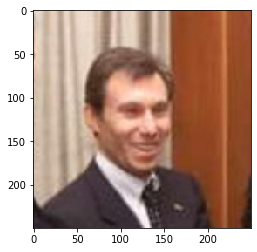

You look like a ...
American water spaniel


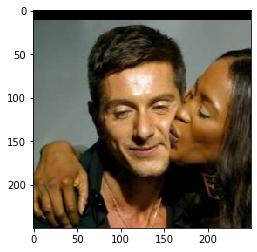

You look like a ...
Chow chow


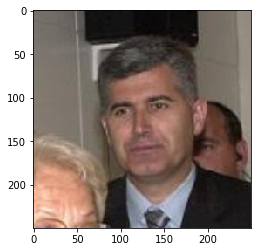

You look like a ...
Nova scotia duck tolling retriever


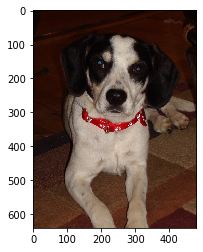

You look like a ...
Bull terrier


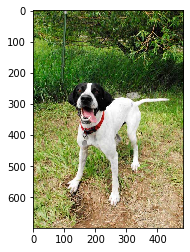

You look like a ...
American staffordshire terrier


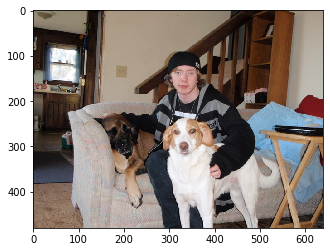

You look like a ...
Bull terrier


In [22]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)